# Libraries

In [11]:
import requests

import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

pd.set_option('display.max_columns', None) # display all columns in DF

# Uploading data

In [19]:
df_orangebook = pd.read_excel('Searchable Database of Orange Book Drug Patents.xlsx', skiprows = 1)
df_openFDA = pd.read_csv('raw_openFDA_data.csv')  
df_medicaid = pd.read_csv('raw_medicaid_data.csv')
df_PPI = pd.read_excel('PPI industry data for Pharmaceutical preparation manufacturing.xlsx', skiprows = 10)

# Data manipulation

### OpenFDA

In [20]:
df_openFDA = df_openFDA.dropna(subset=['openfda.product_ndc'])

Clearing nda

In [21]:
df_openFDA['NDA #'] = df_openFDA['application_number'].str.replace(r'\D', '')
df_openFDA['NDA #'] = pd.to_numeric(df_openFDA['NDA #'])

Unpacking list for ndc

In [22]:
df_openFDA['openfda.product_ndc'] = df_openFDA['openfda.product_ndc'].apply(literal_eval)
df_openFDA = df_openFDA.explode('openfda.product_ndc')

Splitting ndc into labeler and product code

In [23]:
df_temp = df_openFDA['openfda.product_ndc'].str.split("-", n = 1, expand = True)
df_openFDA['labeler_code']= df_temp[0]
df_openFDA['labeler_code'] = pd.to_numeric(df_openFDA['labeler_code'])
df_openFDA['product_code']= df_temp[1]
df_openFDA['product_code'] = pd.to_numeric(df_openFDA['product_code'])

### Medicaid

Clearing labeler and product code

In [24]:
df_medicaid['labeler_code'] = pd.to_numeric(df_medicaid['labeler_code'])
df_medicaid['product_code'] = pd.to_numeric(df_medicaid['product_code'])

Creating a date

In [ ]:
df_medicaid['date'] = 'Q' + df_medicaid['quarter'].astype(str) + ' ' + df_medicaid['year'].astype(str)
df_medicaid['date'] = pd.to_datetime(df_medicaid['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

### PPI

Creating a date

In [ ]:
df_PPI['Period'] = df_PPI['Period'].str.replace(r'\D', '')
df_PPI['Period'] = pd.to_numeric(df_PPI['Period'])
df_PPI['day'] = 1
df_PPI['date'] = pd.to_datetime(dict(year = df_PPI['Year'], month = df_PPI['Period'], day= df_PPI['day']))

Calculating PPI multiplier

In [ ]:
df_PPI['Value'] = pd.to_numeric(df_PPI['Value'])
df_PPI['PPI_multiplier'] = df_PPI['Value'].iloc[-1] / df_PPI['Value']

# Merging data

### Orange Book and OpenFDA

In [67]:
df = pd.merge(df_openFDA, df_orangebook, on = 'NDA #', how = 'left')

### Medicaid and PPI

In [68]:
df_medicaid = pd.merge(df_medicaid, df_PPI, on = 'date', how = 'left')

Adjusting for inflation

In [69]:
df_medicaid['price_per_unit_adj'] = df_medicaid['price_per_unit'] * df_medicaid['PPI_multiplier']

Deleting redundant columns

In [70]:
df_medicaid = df_medicaid.drop(columns=['Series ID', 'Year', 'Period', 'Value', 'Unnamed: 4', 'Unnamed: 5', 'day', 'PPI_multiplier'])

### Orange Book, OpenFDA and Medicaid

In [72]:
df_consolidation_data = pd.merge(df, df_medicaid, on = ['labeler_code', 'product_code'], how = 'inner')

# Downloading output

In [73]:
df_consolidation_data.to_csv('raw_consolidation_data.csv', index = False)

# First figure

In [74]:
df = df_consolidation_data

In [75]:
df['openfda.generic_name'] = df['openfda.generic_name'].apply(literal_eval)
df = df.explode('openfda.generic_name')

In [76]:
df_test = df.loc[df['openfda.generic_name'] == 'TEMAZEPAM']

In [77]:
df_test

,submissions,application_number,sponsor_name,products,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.route,openfda.substance_name,openfda.rxcui,openfda.spl_id,openfda.spl_set_id,openfda.package_ndc,openfda.unii,openfda.nui,openfda.pharm_class_moa,openfda.pharm_class_epc,openfda.pharm_class_cs,openfda.pharm_class_pe,NDA #,labeler_code,product_code,Ingredient(s),Company,Product Name,Approval Date,Earliest Protection DateEarliest Prot. Date,Latest Protection DateLatest Prot. Date,dsad,Months of Additional Protection TimeMonths Add. Prot. Time,Total Number of ProtectionsNum. Prot.,Unique Patents,Number of Orphan Drug ExclusivitiesNum. ODE's,Extensions,dataset,year,quarter,price_per_unit,date,price_per_unit_adj
79106,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA071175,SUN PHARM INDUSTRIES,"[{'product_number': '001', 'reference_drug': '...",['ANDA071175'],['TEMAZEPAM'],TEMAZEPAM,"['Sun Pharmaceutical Industries, Inc.']",53489-648,['HUMAN PRESCRIPTION DRUG'],['ORAL'],['TEMAZEPAM'],"['198241', '198242', '198243', '485489']",['4eeff7a1-a4af-41ac-98cf-2790d40c91df'],['3e4a35f8-77e5-4c9a-aad2-b0aeb98edd66'],"['53489-648-07', '53489-648-06', '53489-648-01...",['CHB1QD2QSS'],"['N0000175694', 'M0002356']",NaN,['Benzodiazepine [EPC]'],['Benzodiazepines [CS]'],NaN,71175,53489,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State Drug Utilization Data 2009,2009,4,7.470170,2009-10-01,13.096563
79107,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA071175,SUN PHARM INDUSTRIES,"[{'product_number': '001', 'reference_drug': '...",['ANDA071175'],['TEMAZEPAM'],TEMAZEPAM,"['Sun Pharmaceutical Industries, Inc.']",53489-648,['HUMAN PRESCRIPTION DRUG'],['ORAL'],['TEMAZEPAM'],"['198241', '198242', '198243', '485489']",['4eeff7a1-a4af-41ac-98cf-2790d40c91df'],['3e4a35f8-77e5-4c9a-aad2-b0aeb98edd66'],"['53489-648-07', '53489-648-06', '53489-648-01...",['CHB1QD2QSS'],"['N0000175694', 'M0002356']",NaN,['Benzodiazepine [EPC]'],['Benzodiazepines [CS]'],NaN,71175,53489,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State Drug Utilization Data 2010,2010,1,7.486951,2010-01-01,12.784805
79108,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA071175,SUN PHARM INDUSTRIES,"[{'product_number': '001', 'reference_drug': '...",['ANDA071175'],['TEMAZEPAM'],TEMAZEPAM,"['Sun Pharmaceutical Industries, Inc.']",53489-648,['HUMAN PRESCRIPTION DRUG'],['ORAL'],['TEMAZEPAM'],"['198241', '198242', '198243', '485489']",['4eeff7a1-a4af-41ac-98cf-2790d40c91df'],['3e4a35f8-77e5-4c9a-aad2-b0aeb98edd66'],"['53489-648-07', '53489-648-06', '53489-648-01...",['CHB1QD2QSS'],"['N0000175694', 'M0002356']",NaN,['Benzodiazepine [EPC]'],['Benzodiazepines [CS]'],NaN,71175,53489,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State Drug Utilization Data 2010,2010,2,7.409480,2010-04-01,12.565078
79109,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA071175,SUN PHARM INDUSTRIES,"[{'product_number': '001', 'reference_drug': '...",['ANDA071175'],['TEMAZEPAM'],TEMAZEPAM,"['Sun Pharmaceutical Industries, Inc.']",53489-648,['HUMAN PRESCRIPTION DRUG'],['ORAL'],['TEMAZEPAM'],"['198241', '198242', '198243', '485489']",['4eeff7a1-a4af-41ac-98cf-2790d40c91df'],['3e4a35f8-77e5-4c9a-aad2-b0aeb98edd66'],"['53489-648-07', '53489-648-06', '53489-648-01...",['CHB1QD2QSS'],"['N0000175694', 'M0002356']",NaN,['Benzodiazepine [EPC]'],['Benzodiazepines [CS]'],NaN,71175,53489,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State Drug Utilization Data 2010,2010,3,7.207920,2010-07-01,12.100299
79110,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA071175,SUN PHARM INDUSTRIES,"[{'product_number': '001', 'reference_drug': '...",['ANDA071175'],['TEMAZEPAM'],TEMAZEPAM,"['Sun Pharmaceutical Industries, Inc.']",53489-648,['HUMAN PRESCRIPTION DRUG'],['ORAL'],['TEMAZEPAM'],"['198241', '198242', '198243', '485489']",['4eeff7a1-a4af-41ac-98cf-2790d40c91df'],['3e4a35f8-77e5-4c9a-aad2-b0a

ACTAVIS ELIZABETH
ALEMBIC PHARMS LTD
AMNEAL PHARMS
NOVEL LABS INC
SPECGX LLC
SUN PHARM INDUSTRIES


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Price Per Unit')]

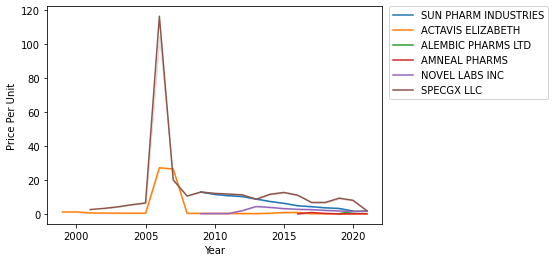

In [78]:
for key, grp in df_test.groupby(['sponsor_name']):
    print(key)

p = sns.lineplot(data=df_test, x = 'year', y = 'price_per_unit_adj', hue = 'sponsor_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit')

In [ ]:
df_test.to_excel('output_for_one_drug.xlsx', index = False)